GEREKLİ KÜTÜPHANELERİN YÜKLENMESİ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

sns.set(style='white', context='notebook', palette='deep')

VERİLERİN BULUTA YÜKLENMESİ

In [2]:
from google.colab import files
uploaded = files.upload()

Saving AB39_2019_binary_0_20.csv to AB39_2019_binary_0_20.csv
Saving AB39_2020_binary_0_20.csv to AB39_2020_binary_0_20.csv
Saving egitim_verisi_binary_0_20.csv to egitim_verisi_binary_0_20.csv


# 0-20 CM VERİ SETİ

EĞİTİM VERİ SETİNİN PANDAS VERİ ÇERÇEVESİNE DÖNÜŞTÜRÜLMESİ

In [3]:
data1 = pd.read_csv('egitim_verisi_binary_0_20.csv', delimiter=';')
data1.head()

,doy,sat_id,amplitude,first_epoch_sec,noe_15sec,min_elev_deg,elev_range_deg,mean_azim_deg,bgn_ratio,decision,est_sd_cm,insitu_sd_cm,abs_diff_cm,Unnamed: 13,Unnamed: 14
0,1,1,9.8168,0,136,5.1417,14.4773,184.90530,3.6704,0,30.1,33.0,2.9,NaN,NaN
1,1,1,8.3507,69150,191,5.0222,19.7932,281.91365,3.8211,1,137.8,33.0,104.8,NaN,NaN
2,1,1,14.6639,85440,62,18.1467,6.7448,186.19400,5.4064,0,53.0,33.0,20.0,NaN,NaN
3,1,2,12.9838,36855,197,5.0455,19.7955,151.66815,4.3691,1,166.3,33.0,133.3,NaN,NaN
4,1,2,14.0578,51945,196,5.2323,19.7033,62.80000,3.9329,0,52.1,33.0,19.1,NaN,NaN


VERİ SETİNDEKİ SINIFLARIN DAĞILIMI

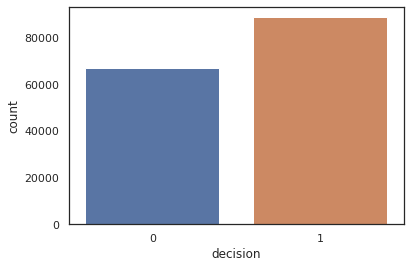

In [4]:
ax = sns.countplot(x="decision", data=data1)

EĞİTİM İÇİN KULLANILACAK SINIFLARIN SAYILARININ EŞİTLENMESİ (UNDERSAMPLING)

In [5]:
count_class_0, count_class_1 = data1.decision.value_counts()

data_10 = data1[data1['decision'] == 0]
data_11 = data1[data1['decision'] == 1]

In [6]:
data_11.shape


(88791, 15)

In [7]:
data_10_under = data_10.sample(count_class_1)
data_11_under = data_11.sample(count_class_1)

data1_test_under = pd.concat([data_10_under, data_11_under], axis=0)

print('Random under-sampling:')
print(data1_test_under.decision.value_counts())

Random under-sampling:
1    67112
0    67112
Name: decision, dtype: int64


BAĞIMLI VE BAĞIMSIZ DEĞİŞKENLERİ İÇEREN SÜTÜNLARIN SEÇİLMESİ

In [8]:
X = data1_test_under.iloc[:,0:8].values  # Independent variables
y = data1_test_under['decision'].values  # Dependent variable

DEĞİŞKEN SÜTÜNLARIN İSİMLERİ

In [9]:
column_names = data1_test_under.iloc[:,0:8].columns
column_names

Index(['doy', 'sat_id', 'amplitude', 'first_epoch_sec', 'noe_15sec',
       'min_elev_deg', 'elev_range_deg', 'mean_azim_deg'],
      dtype='object')

VERİ SETİNİN EĞİTİM VE TEST VERİLERİ OLARAK AYRILMASI (10 KATLI ÇAPRAZLAMA - %10 TEST - %90 EĞİTİM)

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1, shuffle=True)

2 AYRI TEST VERİSİ ÖRNEĞİ ÜZERİNE DENEME (STRATIFIED K-FOLD)

In [11]:
kfold = StratifiedKFold(n_splits=2)

SINIFLANDIRMA ALGORİTMALARININ KABA BİR ŞEKİLDE ÇALIŞTIRILIP DEĞERLENDİRİLMESİ

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


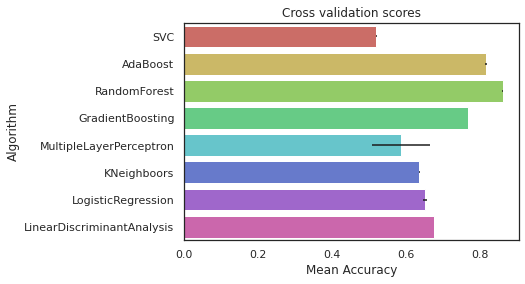

In [12]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","AdaBoost",
"RandomForest","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="hls",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

RANDOM FOREST ALGORİTMASI İLE MODELİN EĞİTİMİ 

In [13]:
RFC_best = RandomForestClassifier(max_features=3, n_estimators=300)

RFC_best.fit(X_train,y_train)

print("score train RFC: ",RFC_best.score(X_train,y_train))
print("score test RFC: ",RFC_best.score(X_test,y_test))

score train RFC:  1.0
score test RFC:  0.8840795649258735


ADABOOST ALGORİTMASI İLE MODELİN EĞİTİMİ

In [14]:
# Adaboost
DTC = DecisionTreeClassifier()

AdaC_best = AdaBoostClassifier(DTC, random_state=7, learning_rate= 0.0001, algorithm = 'SAMME', n_estimators = 1  )

AdaC_best.fit(X_train,y_train)

print("score train AdaC: ",AdaC_best.score(X_train,y_train))
print("score test AdaC: ",AdaC_best.score(X_test,y_test))

score train AdaC:  1.0
score test AdaC:  0.8433286150636966


GRADIENT BOOSTING ALGORİTMASI İLE MODELİN EĞİTİMİ

In [15]:
GBC_best = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_features=0.3)

GBC_best.fit(X_train,y_train)

print("score train GBC: ",GBC_best.score(X_train,y_train))
print("score test GBC: ",GBC_best.score(X_test,y_test))

score train GBC:  0.778842890373424
score test GBC:  0.7750130373239962


ÖĞRENME EĞRİLERİNİN ÇİZDİRİLMESİ

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


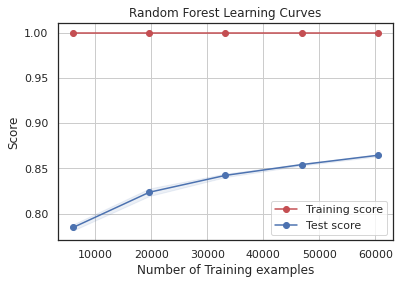

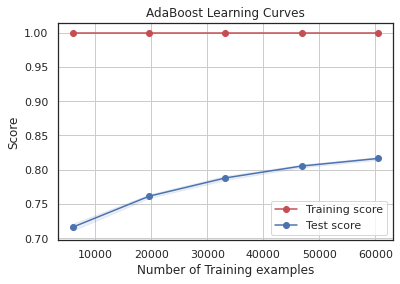

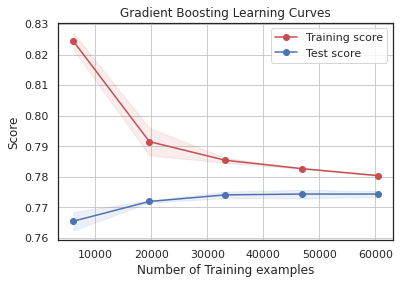

In [16]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Number of Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Test score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(RFC_best,"Random Forest Learning Curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(AdaC_best,"AdaBoost Learning Curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(GBC_best,"Gradient Boosting Learning Curves",X_train,y_train,cv=kfold)

ÖĞRENMEYE ETKİ EDEN DEĞİŞKENLERİN KISMİ AĞIRLIĞI

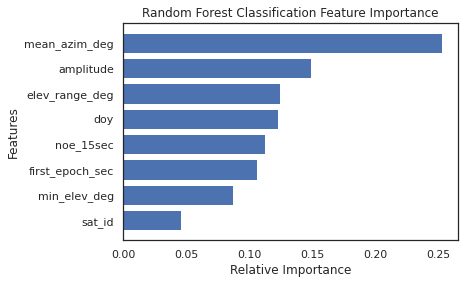

,Feature Names,Relative Importance
1,sat_id,0.045877
5,min_elev_deg,0.087283
3,first_epoch_sec,0.105948
4,noe_15sec,0.112068
0,doy,0.122654
6,elev_range_deg,0.124291
2,amplitude,0.148952
7,mean_azim_deg,0.252926


In [17]:
df_RFC=pd.DataFrame({'Feature Names':column_names, 'Relative Importance':RFC_best.feature_importances_})
df_RFC.sort_values(by='Relative Importance', ascending=True, inplace=True)
plt.barh(df_RFC['Feature Names'],df_RFC['Relative Importance'])
plt.title('Random Forest Classification Feature Importance')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()
df_RFC

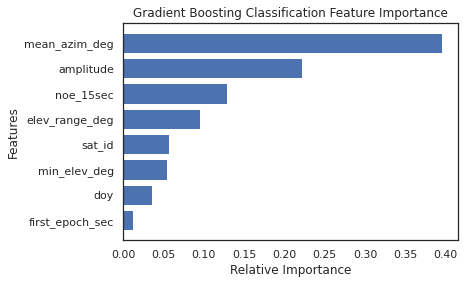

,Feature Names,Relative Importance
3,first_epoch_sec,0.012374
0,doy,0.035769
5,min_elev_deg,0.053843
1,sat_id,0.056184
6,elev_range_deg,0.095761
4,noe_15sec,0.128697
2,amplitude,0.221603
7,mean_azim_deg,0.395769


In [18]:
df_GBC=pd.DataFrame({'Feature Names':column_names, 'Relative Importance':GBC_best.feature_importances_})
df_GBC.sort_values(by='Relative Importance', ascending=True, inplace=True)
plt.barh(df_GBC['Feature Names'],df_GBC['Relative Importance'])
plt.title('Gradient Boosting Classification Feature Importance')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()
df_GBC

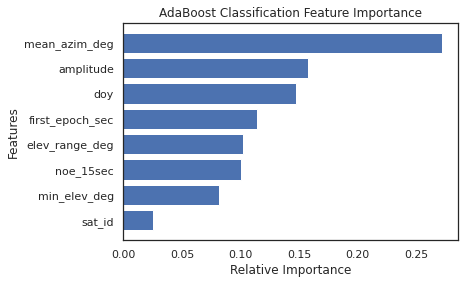

,Feature Names,Relative Importance
1,sat_id,0.024973
5,min_elev_deg,0.081342
4,noe_15sec,0.100574
6,elev_range_deg,0.101932
3,first_epoch_sec,0.114228
0,doy,0.147216
2,amplitude,0.157647
7,mean_azim_deg,0.272087


In [19]:
df_AdaC=pd.DataFrame({'Feature Names':column_names, 'Relative Importance':AdaC_best.feature_importances_})
df_AdaC.sort_values(by='Relative Importance', ascending=True, inplace=True)
plt.barh(df_AdaC['Feature Names'],df_AdaC['Relative Importance'])
plt.title('AdaBoost Classification Feature Importance')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()
df_AdaC

# DOĞRULAMA ÇALIŞMALARI

## 2019 VERİLERİ

DOĞRULAMA VERİ SETİNİN (2019) YÜKLENMESİ

In [20]:
val_19 = pd.read_csv('AB39_2019_binary_0_20.csv', delimiter=';')
val_19.head()

,doy,sat_id,amplitude,first_epoch_sec,noe_15sec,min_elev_deg,elev_range_deg,mean_azim_deg,bgn_ratio,decision,est_sd_cm,insitu_sd_cm,abs_diff_cm,Unnamed: 13,Unnamed: 14
0,1,1,9.8446,11820,285,5.6337,19.3187,69.88450,3.0682,0,31.7,40.6,8.9,NaN,NaN
1,1,1,8.3947,16095,290,5.2304,19.7591,33.95785,3.4108,0,51.3,40.6,10.7,NaN,NaN
2,1,2,4.9522,0,27,5.1738,2.3252,258.44525,2.5602,1,-232.5,40.6,273.1,NaN,NaN
3,1,2,7.9697,22860,191,5.1032,19.7352,153.60095,3.1235,0,44.9,40.6,4.3,NaN,NaN
4,1,2,9.7146,38250,127,12.2833,12.6174,63.67900,2.7221,1,62.0,40.6,21.4,NaN,NaN


In [21]:
val_19.shape

(38700, 15)

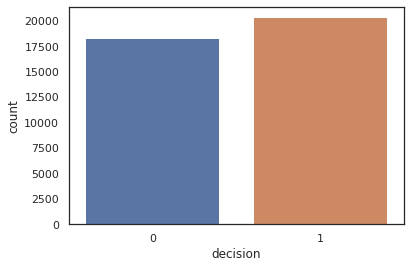

In [22]:
ax = sns.countplot(x="decision", data=val_19)

BAĞIMLI VE BAĞIMSIZ DEĞİŞKENLERİN SEÇİLMESİ

In [23]:
X_val19 = val_19.iloc[:,0:8].values  # Independent variables
y_val19 = val_19['decision'].values  # Dependent variable

RANDOM FOREST ALGORİTMASI İLE SINIFLANDIRMA DOĞRULAMASI


In [24]:
y_predict_RFC = RFC_best.predict(X_val19)

[[12491  5857]
 [ 3222 17130]]
              precision    recall  f1-score   support

           0       0.79      0.68      0.73     18348
           1       0.75      0.84      0.79     20352

    accuracy                           0.77     38700
   macro avg       0.77      0.76      0.76     38700
weighted avg       0.77      0.77      0.76     38700



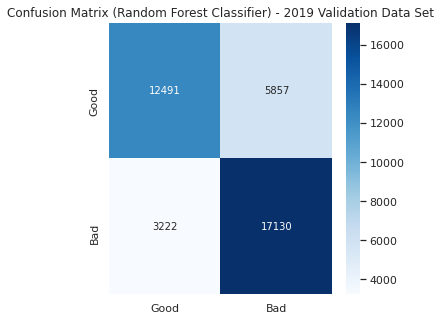

In [25]:
print(confusion_matrix(y_val19, y_predict_RFC))
print(classification_report(y_val19, y_predict_RFC)) 

df_cm_RFC= pd.DataFrame(confusion_matrix(y_val19, y_predict_RFC), index = [i for i in ["Good",  'Bad']],
                  columns = [i for i in ["Good",'Bad']])
plt.figure(figsize = (5,5))
plt.title('Confusion Matrix (Random Forest Classifier) - 2019 Validation Data Set')
sns.heatmap(df_cm_RFC, annot = True, fmt='g', cmap='Blues')

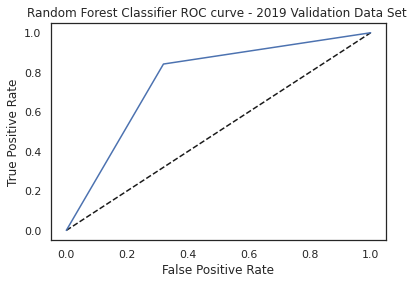

In [26]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val19, y_predict_RFC)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier ROC curve - 2019 Validation Data Set ')
plt.show()

In [27]:
from sklearn.metrics import roc_auc_score
print("Area Under Curve: ", roc_auc_score(y_val19, y_predict_RFC))

Area Under Curve:  0.7612344836823507


GRADIENT BOOSTING ALGORİTMASI İLE SINIFLANDIRMA DOĞRULAMASI

In [28]:
y_predict_GBC = GBC_best.predict(X_val19)

[[12736  5612]
 [ 3306 17046]]
              precision    recall  f1-score   support

           0       0.79      0.69      0.74     18348
           1       0.75      0.84      0.79     20352

    accuracy                           0.77     38700
   macro avg       0.77      0.77      0.77     38700
weighted avg       0.77      0.77      0.77     38700



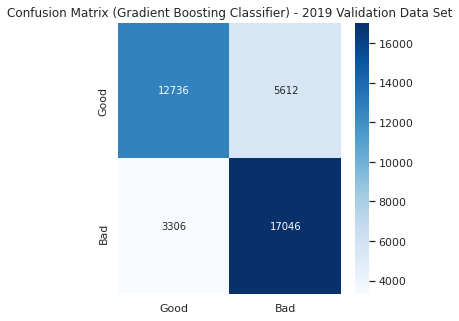

In [29]:
print(confusion_matrix(y_val19, y_predict_GBC))
print(classification_report(y_val19, y_predict_GBC)) 

df_cm_GBC= pd.DataFrame(confusion_matrix(y_val19, y_predict_GBC), index = [i for i in ["Good",  'Bad']],
                  columns = [i for i in ["Good",'Bad']])
plt.figure(figsize = (5,5))
plt.title('Confusion Matrix (Gradient Boosting Classifier) - 2019 Validation Data Set')
sns.heatmap(df_cm_GBC, annot = True, fmt='g', cmap='Blues')

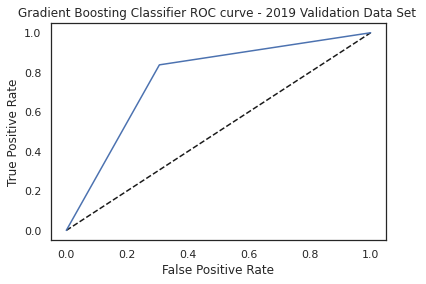

In [30]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val19, y_predict_GBC)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Gradient Boosting Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting Classifier ROC curve - 2019 Validation Data Set ')
plt.show()

In [31]:
print("Area Under Curve: ",roc_auc_score(y_val19, y_predict_GBC))

Area Under Curve:  0.7658472814372858


ADABOOST ALGORİTMASI İLE SINIFLANDIRMA DOĞRULAMASI

In [32]:
y_predict_AdaC = AdaC_best.predict(X_val19)

[[11653  6695]
 [ 5652 14700]]
              precision    recall  f1-score   support

           0       0.67      0.64      0.65     18348
           1       0.69      0.72      0.70     20352

    accuracy                           0.68     38700
   macro avg       0.68      0.68      0.68     38700
weighted avg       0.68      0.68      0.68     38700



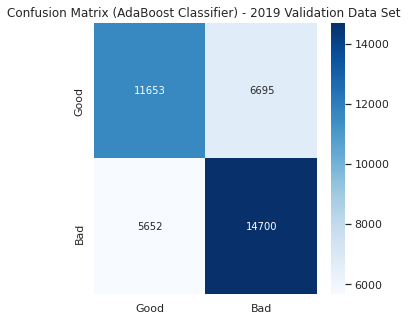

In [33]:
print(confusion_matrix(y_val19, y_predict_AdaC))
print(classification_report(y_val19, y_predict_AdaC)) 

df_cm_AdaC= pd.DataFrame(confusion_matrix(y_val19, y_predict_AdaC), index = [i for i in ["Good",  'Bad']],
                  columns = [i for i in ["Good",'Bad']])
plt.figure(figsize = (5,5))
plt.title('Confusion Matrix (AdaBoost Classifier) - 2019 Validation Data Set ')
sns.heatmap(df_cm_AdaC, annot = True, fmt='g', cmap='Blues')

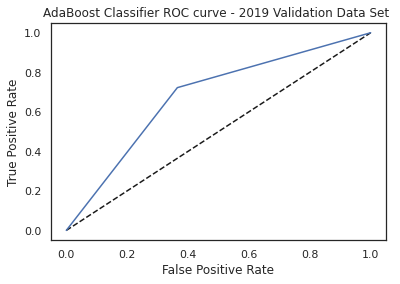

In [34]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val19, y_predict_AdaC)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='AdaBoost Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost Classifier ROC curve - 2019 Validation Data Set ')
plt.show()

In [35]:
print("Area Under Curve: ",roc_auc_score(y_val19, y_predict_AdaC))

Area Under Curve:  0.6786989147961219


SINIFLANDIRILMA SONUÇLARININ EXCEL'E AKTARIMI

In [36]:
val_19['predicted_decision_RF'] = y_predict_RFC.tolist()
val_19['predicted_decision_GB'] = y_predict_GBC.tolist()
val_19['predicted_decision_Ada'] = y_predict_AdaC.tolist()
val_19.head()

,doy,sat_id,amplitude,first_epoch_sec,noe_15sec,min_elev_deg,elev_range_deg,mean_azim_deg,bgn_ratio,decision,est_sd_cm,insitu_sd_cm,abs_diff_cm,Unnamed: 13,Unnamed: 14,predicted_decision_RF,predicted_decision_GB,predicted_decision_Ada
0,1,1,9.8446,11820,285,5.6337,19.3187,69.88450,3.0682,0,31.7,40.6,8.9,NaN,NaN,0,0,1
1,1,1,8.3947,16095,290,5.2304,19.7591,33.95785,3.4108,0,51.3,40.6,10.7,NaN,NaN,0,0,0
2,1,2,4.9522,0,27,5.1738,2.3252,258.44525,2.5602,1,-232.5,40.6,273.1,NaN,NaN,1,1,1
3,1,2,7.9697,22860,191,5.1032,19.7352,153.60095,3.1235,0,44.9,40.6,4.3,NaN,NaN,0,1,1
4,1,2,9.7146,38250,127,12.2833,12.6174,63.67900,2.7221,1,62.0,40.6,21.4,NaN,NaN,1,1,1


In [37]:
file_name = '2019_predicted_biclass-020cm.xlsx'
val_19.to_excel(file_name)

## 2020 VERİLERİ

DOĞRULAMA VERİ SETİNİN (2020) YÜKLENMESİ

In [38]:
val_20 = pd.read_csv('AB39_2020_binary_0_20.csv', delimiter=';')
val_20.head()

,doy,sat_id,amplitude,first_epoch_sec,noe_15sec,min_elev_deg,elev_range_deg,mean_azim_deg,bgn_ratio,decision,est_sd_cm,insitu_sd_cm,abs_diff_cm,Unnamed: 13,Unnamed: 14
0,1,1,9.4402,8085,293,5.2349,19.7399,68.09035,3.075484607,0,16.0,27.9,11.9,NaN,NaN
1,1,1,17.9102,15555,293,5.1676,19.8127,20.10480,4.452393974,0,29.7,27.9,1.8,NaN,NaN
2,1,1,12.3846,51105,186,5.1617,19.6820,280.24775,3.048066747,0,24.2,27.9,3.7,NaN,NaN
3,1,1,6.6518,67440,153,8.2747,16.6849,182.08240,2.738155024,1,84.7,27.9,56.8,NaN,NaN
4,1,2,7.2395,19215,180,6.1304,18.6865,151.83860,2.848290514,1,66.4,27.9,38.5,NaN,NaN


In [39]:
val_20.shape

(38677, 15)

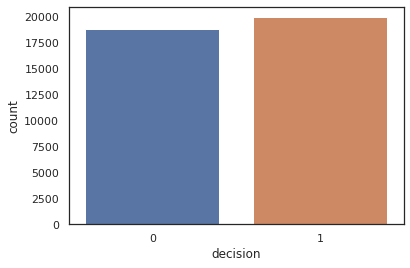

In [40]:
ax = sns.countplot(x="decision", data=val_20)

BAĞIMLI VE BAĞIMSIZ DEĞİŞKENLERİN SEÇİMİ

In [41]:
X_val20 = val_20.iloc[:,0:8].values  # Independent variables
y_val20 = val_20['decision'].values  # Dependent variable

RANDOM FOREST ALGORİTMASI İLE SINIFLANDIRMA DOĞRULAMASI

In [42]:
y_predict_RFC = RFC_best.predict(X_val20)

[[11844  6920]
 [ 2505 17408]]
              precision    recall  f1-score   support

           0       0.83      0.63      0.72     18764
           1       0.72      0.87      0.79     19913

    accuracy                           0.76     38677
   macro avg       0.77      0.75      0.75     38677
weighted avg       0.77      0.76      0.75     38677



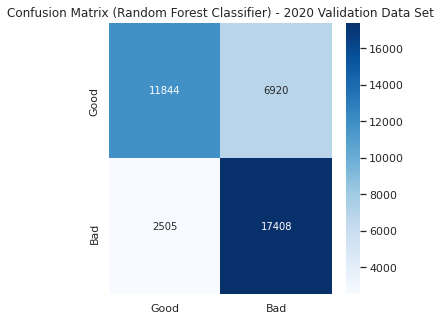

In [43]:
print(confusion_matrix(y_val20, y_predict_RFC))
print(classification_report(y_val20, y_predict_RFC)) 

df_cm_RFC= pd.DataFrame(confusion_matrix(y_val20, y_predict_RFC), index = [i for i in ["Good",  'Bad']],
                  columns = [i for i in ["Good",'Bad']])
plt.figure(figsize = (5,5))
plt.title('Confusion Matrix (Random Forest Classifier) - 2020 Validation Data Set')
sns.heatmap(df_cm_RFC, annot = True, fmt='g', cmap='Blues')

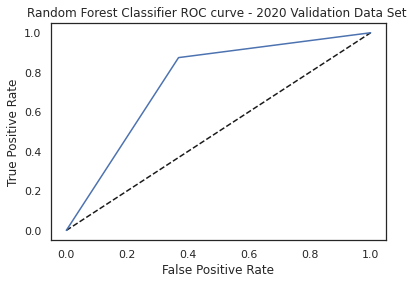

In [44]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val20, y_predict_RFC)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier ROC curve - 2020 Validation Data Set ')
plt.show()

In [45]:
from sklearn.metrics import roc_auc_score
print("Area Under Curve: ", roc_auc_score(y_val20, y_predict_RFC))

Area Under Curve:  0.7527057398040032


GRADIENT BOOSTING ALGORİTMASI İLE SINIFLANDIRMA DOĞRULAMASI

In [46]:
y_predict_GBC = GBC_best.predict(X_val20)

[[12545  6219]
 [ 2565 17348]]
              precision    recall  f1-score   support

           0       0.83      0.67      0.74     18764
           1       0.74      0.87      0.80     19913

    accuracy                           0.77     38677
   macro avg       0.78      0.77      0.77     38677
weighted avg       0.78      0.77      0.77     38677



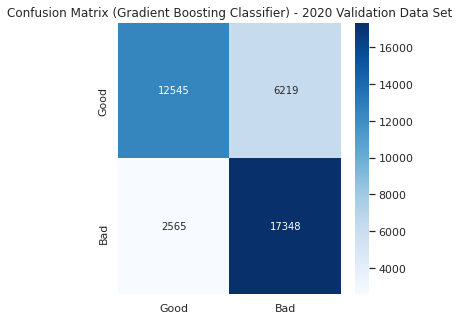

In [47]:
print(confusion_matrix(y_val20, y_predict_GBC))
print(classification_report(y_val20, y_predict_GBC)) 

df_cm_GBC= pd.DataFrame(confusion_matrix(y_val20, y_predict_GBC), index = [i for i in ["Good",  'Bad']],
                  columns = [i for i in ["Good",'Bad']])
plt.figure(figsize = (5,5))
plt.title('Confusion Matrix (Gradient Boosting Classifier) - 2020 Validation Data Set')
sns.heatmap(df_cm_GBC, annot = True, fmt='g', cmap='Blues')

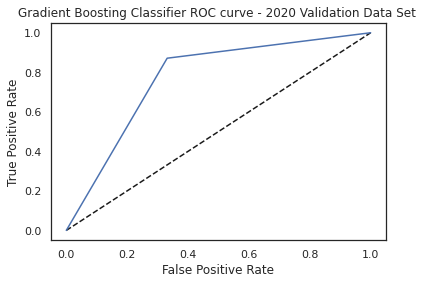

In [48]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val20, y_predict_GBC)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Gradient Boosting Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting Classifier ROC curve - 2020 Validation Data Set ')
plt.show()

In [49]:
print("Area Under Curve: ",roc_auc_score(y_val20, y_predict_GBC))

Area Under Curve:  0.7698785723546544


ADABOOST ALGORİTMASI İLE SINIFLANDIRMA DOĞRULAMASI

In [50]:
y_predict_AdaC = AdaC_best.predict(X_val20)

[[11120  7644]
 [ 5574 14339]]
              precision    recall  f1-score   support

           0       0.67      0.59      0.63     18764
           1       0.65      0.72      0.68     19913

    accuracy                           0.66     38677
   macro avg       0.66      0.66      0.66     38677
weighted avg       0.66      0.66      0.66     38677



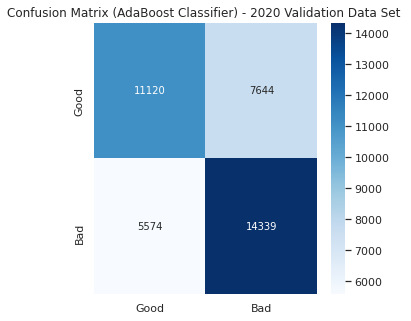

In [51]:
print(confusion_matrix(y_val20, y_predict_AdaC))
print(classification_report(y_val20, y_predict_AdaC)) 

df_cm_AdaC= pd.DataFrame(confusion_matrix(y_val20, y_predict_AdaC), index = [i for i in ["Good",  'Bad']],
                  columns = [i for i in ["Good",'Bad']])
plt.figure(figsize = (5,5))
plt.title('Confusion Matrix (AdaBoost Classifier) - 2020 Validation Data Set ')
sns.heatmap(df_cm_AdaC, annot = True, fmt='g', cmap='Blues')

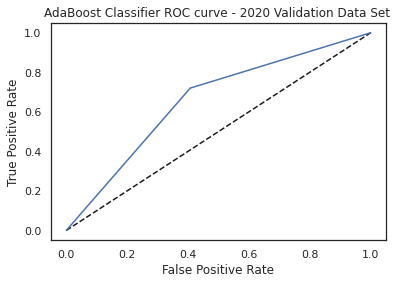

In [52]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val20, y_predict_AdaC)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='AdaBoost Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost Classifier ROC curve - 2020 Validation Data Set ')
plt.show()

In [53]:
print("Area Under Curve: ",roc_auc_score(y_val20, y_predict_AdaC))

Area Under Curve:  0.6563532661042707


SINIFLANDIRILMA SONUÇLARININ EXCEL'E AKTARIMI

In [54]:
val_20['predicted_decision_RF'] = y_predict_RFC.tolist()
val_20['predicted_decision_GB'] = y_predict_GBC.tolist()
val_20['predicted_decision_Ada'] = y_predict_AdaC.tolist()
val_20.head()

,doy,sat_id,amplitude,first_epoch_sec,noe_15sec,min_elev_deg,elev_range_deg,mean_azim_deg,bgn_ratio,decision,est_sd_cm,insitu_sd_cm,abs_diff_cm,Unnamed: 13,Unnamed: 14,predicted_decision_RF,predicted_decision_GB,predicted_decision_Ada
0,1,1,9.4402,8085,293,5.2349,19.7399,68.09035,3.075484607,0,16.0,27.9,11.9,NaN,NaN,1,0,0
1,1,1,17.9102,15555,293,5.1676,19.8127,20.10480,4.452393974,0,29.7,27.9,1.8,NaN,NaN,0,0,0
2,1,1,12.3846,51105,186,5.1617,19.6820,280.24775,3.048066747,0,24.2,27.9,3.7,NaN,NaN,1,0,1
3,1,1,6.6518,67440,153,8.2747,16.6849,182.08240,2.738155024,1,84.7,27.9,56.8,NaN,NaN,1,1,1
4,1,2,7.2395,19215,180,6.1304,18.6865,151.83860,2.848290514,1,66.4,27.9,38.5,NaN,NaN,1,1,1


In [55]:
file_name = '2020_predicted_biclass-020cm.xlsx'
val_20.to_excel(file_name)